In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from osgeo import gdal

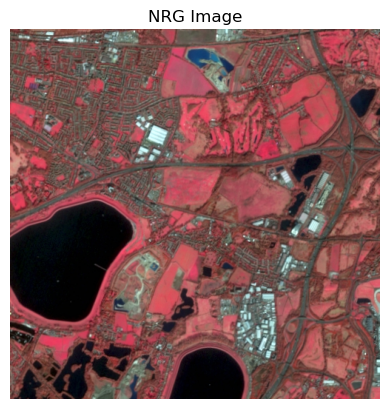

In [ ]:
# Read the image using OpenCV
nrg = cv2.imread("../data/20230215-SE2B-CGG-GBR-MS3-L3-NRG-preview.jpg", cv2.IMREAD_COLOR)

# Render the image using Matplotlib
plt.imshow(cv2.cvtColor(nrg, cv2.COLOR_BGR2RGB))
plt.title('NRG Image')
plt.axis('off')
plt.show()

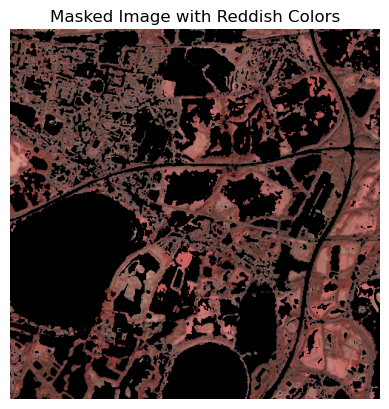

In [3]:
# Convert the image to HSV color space
hsv = cv2.cvtColor(nrg, cv2.COLOR_BGR2HSV)

# Define the range for reddish colors in HSV
lower_red = np.array([0, 50, 50])
upper_red = np.array([10, 255, 255])

# Create a mask for the reddish colors
mask = cv2.inRange(hsv, lower_red, upper_red)

# Apply the mask to the original image
masked_image = cv2.bitwise_and(nrg, nrg, mask=mask)

# Display the masked image
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title('Masked Image with Reddish Colors')
plt.axis('off')
plt.show()

In [ ]:
# Map and LIDAR data
img = cv2.imread("../data/20230215-SE2B-CGG-GBR-MS3-L3-RGB-preview.jpg", cv2.IMREAD_COLOR)
lidar = gdal.Open("../data/DSM_TQ0075_P_12757_20230109_20230315.tif")
lidar_band = lidar.GetRasterBand(1)
lidar_data = lidar_band.ReadAsArray()


/usr/lib/python3/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


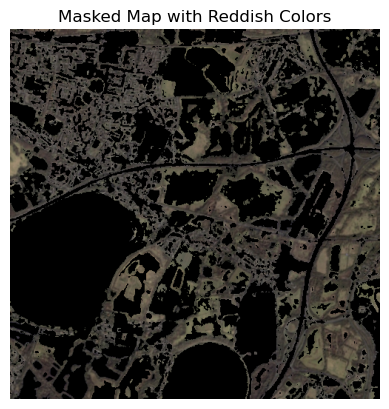

In [5]:
# Apply the mask to the original image
masked_map = cv2.bitwise_and(img, img, mask=mask)

# Display the masked map
plt.imshow(cv2.cvtColor(masked_map, cv2.COLOR_BGR2RGB))
plt.title('Masked Map with Reddish Colors')
plt.axis('off')
plt.show()

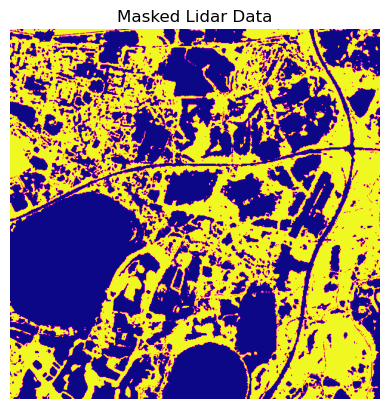

In [6]:
# Normalize the lidar data to the range 0-255
lidar_normalized = cv2.normalize(lidar_data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Resize the mask to match the dimensions of the lidar data
mask_resized = cv2.resize(mask, (lidar_normalized.shape[1], lidar_normalized.shape[0]), interpolation=cv2.INTER_NEAREST)

# Apply the resized mask to the normalized lidar data
masked_lidar = cv2.bitwise_and(lidar_normalized, lidar_normalized, mask=mask_resized)

# Display the masked lidar data
plt.imshow(masked_lidar, cmap='plasma')
plt.title('Masked Lidar Data')
plt.axis('off')
plt.show()

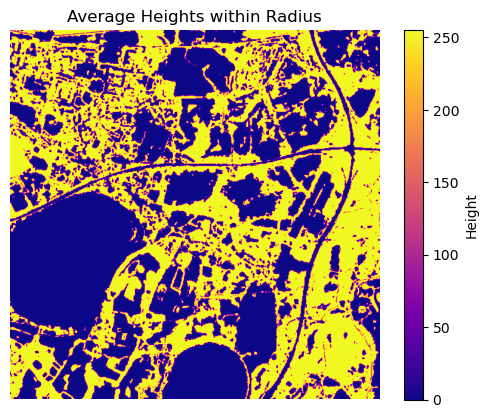

In [13]:
def calculate_average_height_within_radius(grid_data, grid_size_x, grid_size_y, radius):
    average_heights = np.full((grid_size_y, grid_size_x), np.nan)
    
    for i in range(grid_size_y):
        for j in range(grid_size_x):
            y_min = max(0, i - radius)
            y_max = min(grid_size_y, i + radius + 1)
            x_min = max(0, j - radius)
            x_max = min(grid_size_x, j + radius + 1)
            
            window = grid_data[y_min:y_max, x_min:x_max]
            valid_values = window[np.isfinite(window)]
            
            if valid_values.size > 0:
                average_heights[i, j] = np.mean(valid_values)
    
    return average_heights

# Define the grid size based on the masked lidar data dimensions
n = 1
grid_size_x, grid_size_y = masked_lidar.shape[1] // n, masked_lidar.shape[0] // n

# Calculate the average height within the specified radius
radius = 3
average_heights = calculate_average_height_within_radius(masked_lidar, grid_size_x, grid_size_y, radius)

# Display the average heights
plt.imshow(average_heights, cmap='plasma')
plt.title('Average Heights within Radius')
plt.colorbar(label='Height')
plt.axis('off')
plt.show()

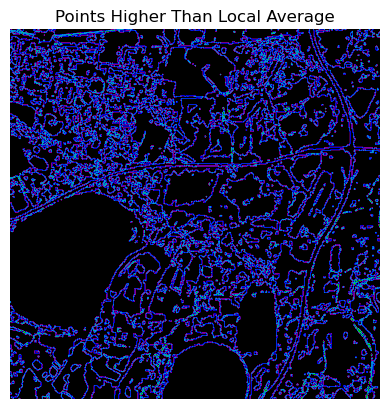

In [14]:
# Reshape the average heights to match the dimensions of masked_lidar
reshaped_average_heights = np.resize(average_heights, masked_lidar.shape)

# Create a boolean mask for points higher than their local average
higher_than_local_average = masked_lidar > reshaped_average_heights

# Display the mask
plt.imshow(higher_than_local_average, cmap='nipy_spectral')
plt.title('Points Higher Than Local Average')
plt.axis('off')
plt.show()

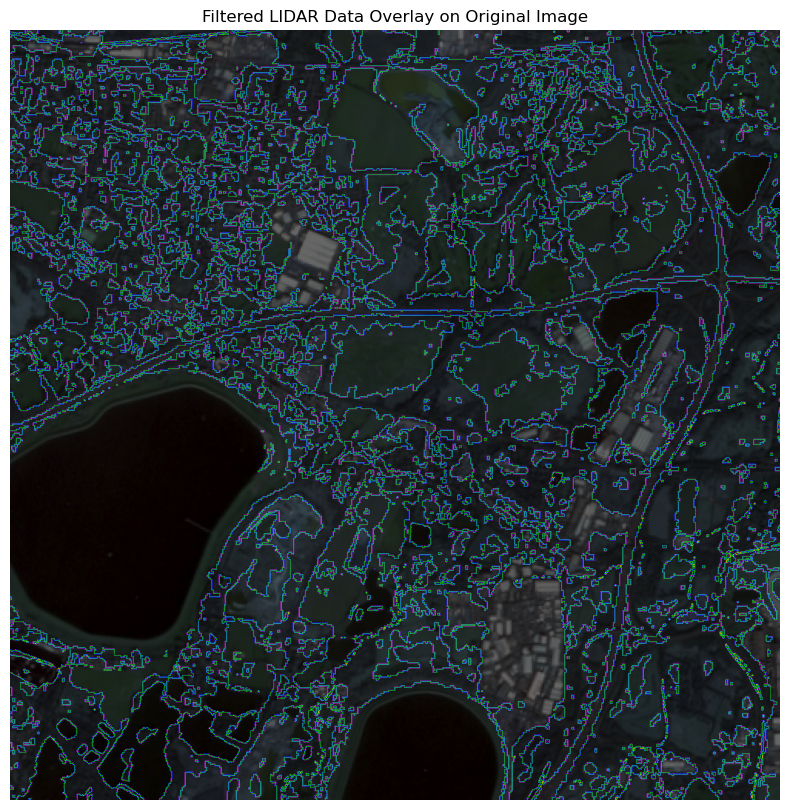

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original image
ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])

# Overlay the filtered LIDAR data with transparency
ax.imshow(higher_than_local_average, cmap='nipy_spectral', alpha=0.6, extent=[0, img.shape[1], 0, img.shape[0]])

ax.set_title('Filtered LIDAR Data Overlay on Original Image')
ax.axis('off')

plt.show()

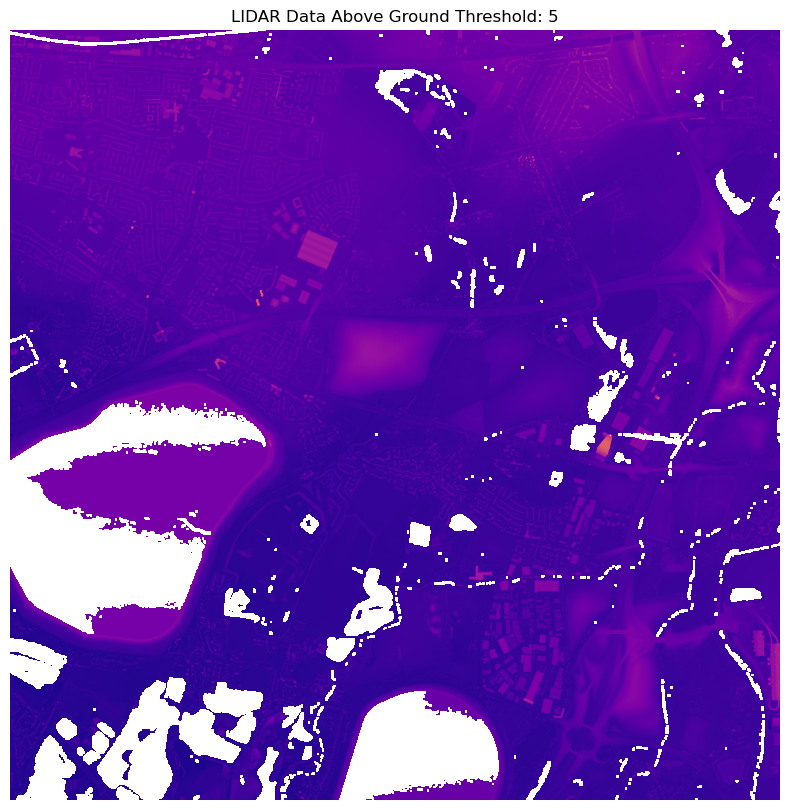

In [18]:
ground_threshold = 5

# Create a mask for areas above the ground threshold
above_ground_mask = lidar_data > ground_threshold

# Apply the mask to the LIDAR data
above_ground_lidar_data = np.where(above_ground_mask, lidar_data, np.nan)

# Plot the filtered LIDAR data
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(above_ground_lidar_data, cmap='plasma')
ax.set_title(f'LIDAR Data Above Ground Threshold: {ground_threshold}')
ax.axis('off')

plt.show()

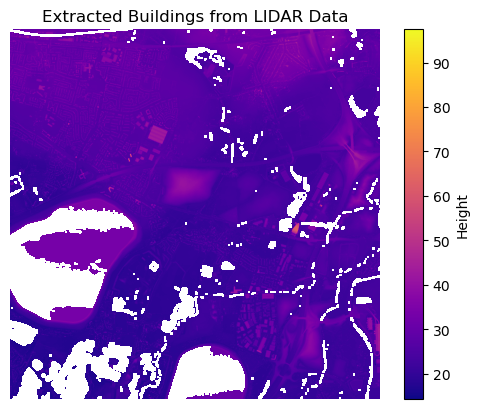

In [ ]:
# Define the height threshold for buildings
building_threshold = 10  # Adjust this value based on your data

# Create a mask for areas above the building threshold
building_mask = lidar_data > building_threshold

# Apply the mask to the LIDAR data to extract buildings
buildings_lidar_data = np.where(building_mask, lidar_data, np.nan)

# Plot the extracted buildings
plt.imshow(buildings_lidar_data, cmap='plasma')
plt.title('Extracted Buildings from LIDAR Data')
plt.colorbar(label='Height')
plt.axis('off')
plt.show()